# Author: Abdullah Moosa 03/11/2024

### **In this notebook the data will be applied on both the Categorical dataset and the Binary one(Dataset 1 and 2)**

##### This notebook implements Multi-Layer Perceptron (MLP) models using PyTorch for binary classification tasks related to lung cancer detection. It systematically explores various hyperparameter configurations, performs cross-validation to assess model performance, and provides comprehensive analysis and visualization of the results. The experiments focus on understanding the effects of different model parameters and data complexities on the generalization capabilities of neural networks.[https://medium.com/deep-learning-study-notes/multi-layer-perceptron-mlp-in-pytorch-21ea46d50e62]

## Importing Libraries

In [181]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
import os
import ast

In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


This notebook uses cuda for gpu acceleration , because it speeds up training time and this can be accessed via the framework Pytorch, which is a popular framework for ML application.

# **Application on Dataset 1**

## Dataset loading and Preprocessing

In [100]:
# load and preprocess data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    X = df.drop(columns=['LUNG_CANCER']).values #drop the target coloumn LUNG_CANCER
    y = df['LUNG_CANCER'].values

    # Check if labels are 1 and 2, and map to 0 and 1 if needed (for og_dataset)
    if set(np.unique(y)) == {1, 2}:
        y = np.where(y == 1, 0, 1)

    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Train-test split with test set as 20%
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42)

    # Convert to torch tensors 
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

    return X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor

This code block is responsible for loading the dataset, standardizing the features, and splitting it into training and testing sets. The data is then converted into PyTorch tensors of type float 32 as required by the torch and moved to the GPU.

## MLP initialization

In [101]:
# Define a configurable MLP architecture with PyTorch
class ConfigurableMLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation):
        super(ConfigurableMLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for neurons in hidden_layers:
            layers.append(nn.Linear(prev_dim, neurons))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            prev_dim = neurons
        layers.append(nn.Linear(prev_dim, 1))  # Output layer
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    # forward propogation
    def forward(self, x):
        return self.network(x)

This code defines a customizable Multi-Layer Perceptron architecture. It allows varying the number of hidden layers, the number of neurons in each layer, and the activation function. The output layer uses a sigmoid activation function suitable for binary classification tasks.[https://www.datacamp.com/tutorial/introduction-to-activation-functions-in-neural-networks]

## Set parameters and configurables

In [102]:
# List of dataset paths to evaluate
dataset_paths = [
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_ef_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_nrml_b.csv',
    r'/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/1_og_b.csv'
]

# Define hyperparameter grid
param_grid = {
    'dataset_path': dataset_paths,
    'hidden_layers': [
        [15], [15, 15], [15, 15, 15], [15, 15, 15, 15], [15, 15, 15, 15, 15]
    ],
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'sgd', 'rmsprop'],
    'epochs': [10, 25, 50],
}

# Fixed batch size
batch_size = 32

# Perform grid search with 10 fold crossvalidation
results = []
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

This code defines the paths to the datasets and establishes a grid of hyperparameters for the grid search. The hyperparameters include variations in hidden layers, learning rates, activation functions, optimizers, and the number of training epochs, while keeping batch_size fixed due to gpu constrains

## Hyperparameter Grid Search

In [120]:
# create a nested loop for each hyperparameter
for dataset_path in param_grid['dataset_path']:
    for hidden_layers in param_grid['hidden_layers']:
        for learning_rate in param_grid['learning_rate']:
            for activation in param_grid['activation']:
                for optimizer_name in param_grid['optimizer']:
                    for epoch in param_grid['epochs']:
                        f1_scores = []
                        dataset_name = os.path.basename(dataset_path)
                        
                        # Load and preprocess data for the current dataset
                        X_train, X_test, y_train, y_test = load_and_preprocess_data(dataset_path)
                        
                        # Perform K-Fold Cross-Validation
                        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train.cpu().numpy(), y_train.cpu().numpy().ravel()), 1):
                            X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
                            y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

                            # Build the model
                            model = ConfigurableMLP(input_dim=X_train.shape[1], hidden_layers=hidden_layers, activation=activation).to(device)
                            
                            # Define optimizer
                            if optimizer_name == 'adam':
                                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                            elif optimizer_name == 'sgd':
                                optimizer = optim.SGD(model.parameters(), lr=learning_rate)
                            elif optimizer_name == 'rmsprop':
                                optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
                            
                            # Define loss function binary cross entropy
                            criterion = nn.BCELoss()

                            # Training loop
                            model.train()
                            for epoch_num in range(1, epoch + 1):
                                optimizer.zero_grad()
                                y_pred = model(X_train_fold)
                                loss = criterion(y_pred, y_train_fold)
                                loss.backward()
                                optimizer.step()
                            
                            # Evaluate the model
                            model.eval()
                            with torch.no_grad():
                                y_val_pred = (model(X_val_fold) > 0.5).cpu().numpy().astype(int)
                            f1 = f1_score(y_val_fold.cpu().numpy(), y_val_pred, zero_division=0)
                            f1_scores.append(f1)

                        # Record the average F1-score for every configuration
                        avg_f1 = np.mean(f1_scores)
                        results.append({
                            'dataset': dataset_name,
                            'hidden_layers': hidden_layers,
                            'learning_rate': learning_rate,
                            'activation': activation,
                            'optimizer': optimizer_name,
                            'epochs': epoch,
                            'avg_f1_score': avg_f1
                        })


# Convert results to a pandas DataFrame for analysis
results_df = pd.DataFrame(results)

# Sort by F1-score to identify the top 3 best configurations
top_3_configs = results_df.sort_values(by='avg_f1_score', ascending=False).head(3)
print(top_3_configs)


# Save the entire results DataFrame to a CSV file
results_df.to_csv('hyperparameter_search_results.csv', index=False)

           dataset hidden_layers  learning_rate activation optimizer  epochs  \
2100  1_nrml_b.csv      [15, 15]           0.01       relu   rmsprop      50   
749     1_og_b.csv      [15, 15]           0.01       relu   rmsprop      25   
708     1_og_b.csv          [15]           0.10       relu      adam      50   

      avg_f1_score  
2100      0.966307  
749       0.960961  
708       0.960944  


This loop iterates over each combination of hyperparameters and datasets. For each configuration, it trains the MLP model using Stratified 10-Fold Cross-Validation. After training, it evaluates the model's performance on the validation folds and records the average F1-Score for the configuration. The chosen loss function is binary cross entropy loss [https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/]. Finally, all the results of each configuration is stored inside a pandas dataframe for further analysis and also saved in a csv file.

## Analysis of various hyper parameters

### Analysis of number of hidden layers vs F1 score

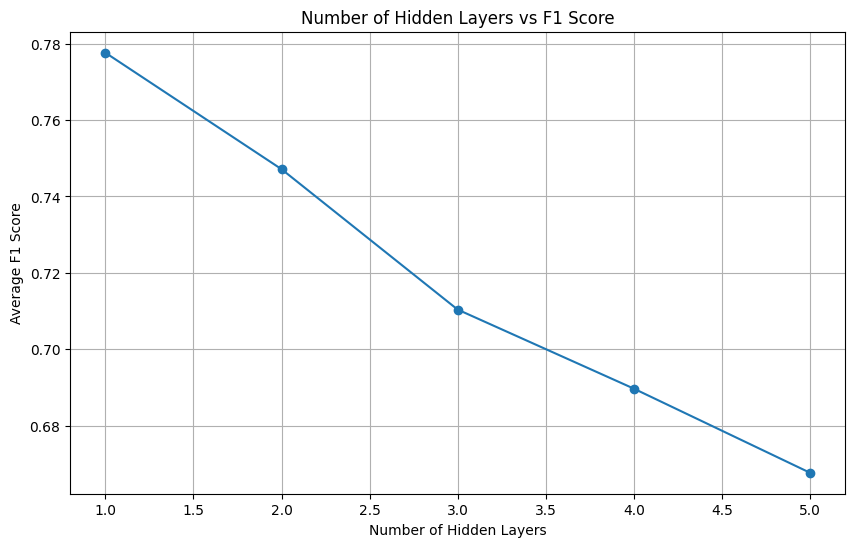


Average F1-Score by Number of Hidden Layers:
 num_hidden_layers  avg_f1_score
                 1      0.777661
                 2      0.747152
                 3      0.710372
                 4      0.689666
                 5      0.667633


In [128]:
# Calculate the number of hidden layers for each configuration
results_df['num_hidden_layers'] = results_df['hidden_layers'].apply(len)


hidden_layer_f1 = results_df.groupby('num_hidden_layers')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
plt.plot(hidden_layer_f1.index, hidden_layer_f1.values, marker='o', linestyle='-')
plt.title('Number of Hidden Layers vs F1 Score')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Average F1 Score')
plt.grid(True)
plt.show()


print("\nAverage F1-Score by Number of Hidden Layers:")
print(hidden_layer_f1.reset_index().to_string(index=False))

### Analysis of number of dataset vs F1 score

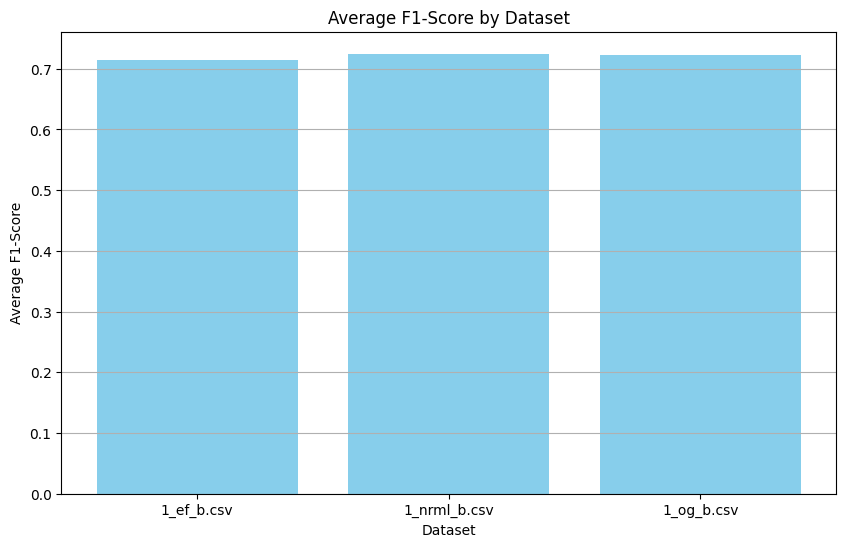


Average F1-Score by Dataset
 index      dataset  avg_f1_score
     0   1_ef_b.csv      0.714139
     1 1_nrml_b.csv      0.725047
     2   1_og_b.csv      0.722637


In [129]:
dataset_analysis = results_df.groupby('dataset')['avg_f1_score'].mean().reset_index()
plt.figure(figsize=(10, 6))
bars = plt.bar(dataset_analysis['dataset'], dataset_analysis['avg_f1_score'], color='skyblue')
plt.title("Average F1-Score by Dataset")
plt.xlabel("Dataset")
plt.ylabel("Average F1-Score")
plt.grid(axis='y')
plt.show()


print("\nAverage F1-Score by Dataset")
print(dataset_analysis.reset_index().to_string(index=False))

### Analysis of number of Learning rate vs F1 score

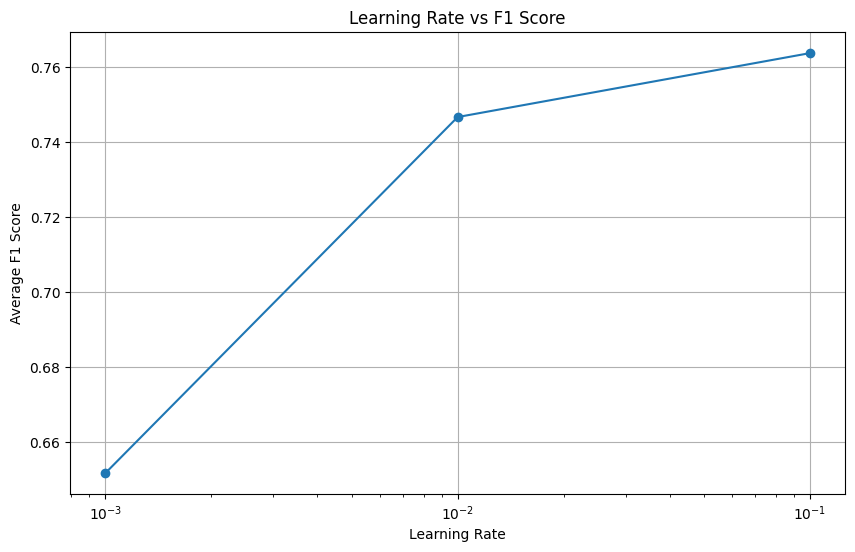


Average F1-Score by Learning Rate:
 learning_rate  avg_f1_score
         0.001      0.651735
         0.010      0.746694
         0.100      0.763743


In [130]:
learning_rate_f1 = results_df.groupby('learning_rate')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
plt.plot(learning_rate_f1.index, learning_rate_f1.values, marker='o', linestyle='-')
plt.title('Learning Rate vs F1 Score')
plt.xlabel('Learning Rate')
plt.ylabel('Average F1 Score')
plt.xscale('log')
plt.grid(True)
plt.show()

print("\nAverage F1-Score by Learning Rate:")
print(learning_rate_f1.reset_index().to_string(index=False))


### Analysis of number of activation function vs F1 score

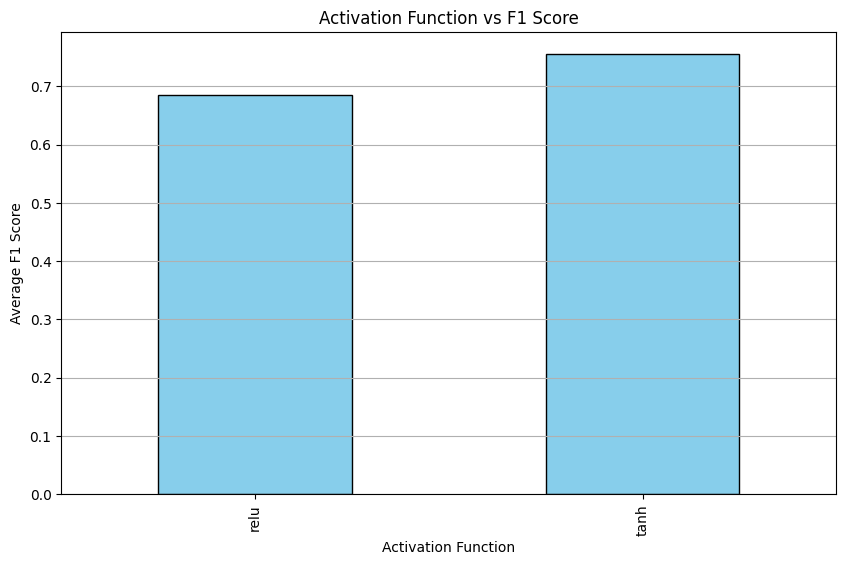


Average F1-Score by Activation Function:
activation  avg_f1_score
      relu      0.685301
      tanh      0.755367


In [131]:
activation_f1 = results_df.groupby('activation')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
activation_f1.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Activation Function vs F1 Score')
plt.xlabel('Activation Function')
plt.ylabel('Average F1 Score')
plt.grid(axis='y')
plt.show()


print("\nAverage F1-Score by Activation Function:")
print(activation_f1.reset_index().to_string(index=False))

### Analysis of number of optimizer vs F1 score

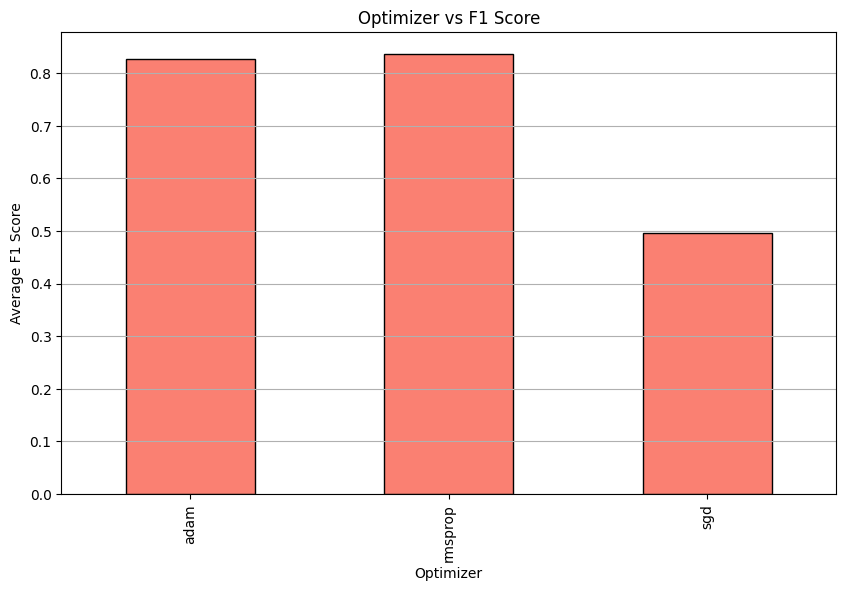


Average F1-Score by Optimizer:
optimizer  avg_f1_score
     adam      0.827236
  rmsprop      0.836734
      sgd      0.496754


In [134]:
optimizer_f1 = results_df.groupby('optimizer')['avg_f1_score'].mean()
plt.figure(figsize=(10, 6))
optimizer_f1.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Optimizer vs F1 Score')
plt.xlabel('Optimizer')
plt.ylabel('Average F1 Score')
plt.grid(axis='y')
plt.show()

print("\nAverage F1-Score by Optimizer:")
print(optimizer_f1.reset_index().to_string(index=False))

### Analysis of number of number of epochs vs F1 score

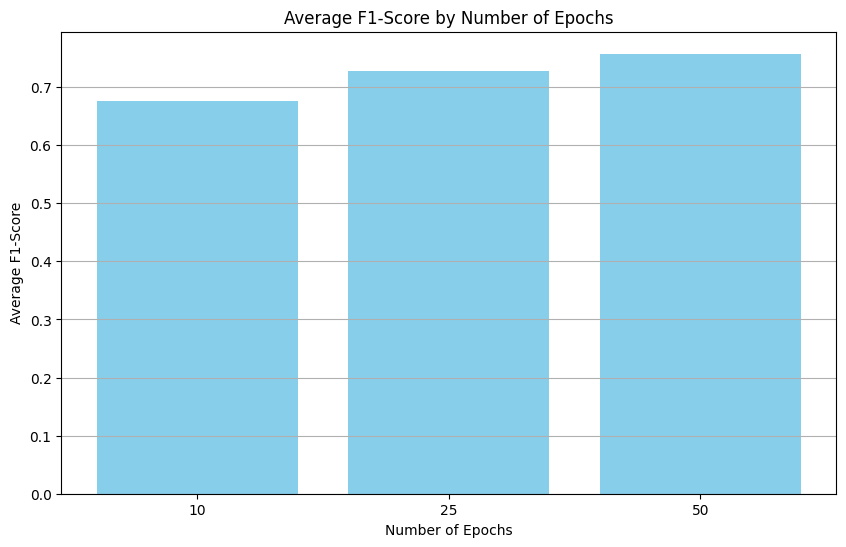


Average F1-Score by Number of Epochs:
 epochs  avg_f1_score
     10      0.676631
     25      0.726922
     50      0.757336


In [ ]:
epochs_analysis = results_df.groupby('epochs')['avg_f1_score'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.bar(epochs_analysis['epochs'].astype(str), epochs_analysis['avg_f1_score'], color='skyblue')
plt.title("Average F1-Score by Number of Epochs")
plt.xlabel("Number of Epochs")
plt.ylabel("Average F1-Score")
plt.grid(axis='y')
plt.show()

print("\nAverage F1-Score by Number of Epochs:")
print(epochs_analysis.to_string(index=False))

## Analysis the best configuration

### Define metrics and configurations

In [173]:
# Function to compute comprehensive metrics
def compute_metrics(y_true, y_pred, y_prob):

    cm = confusion_matrix(y_true, y_pred)
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
    else:
        TN, FP, FN, TP = 0, 0, 0, 0
        if len(cm) == 1:
            if cm[0][0] == 1:
                TP = 1
            else:
                TN = 1

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    sensitivity = recall
    
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = np.nan
    
    return {
        'Accuracy': accuracy,
        'TP': TP,
        'FP': FP,
        'TN': TN,
        'FN': FN,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }


# Function to load the dataset as done earlier
def load_data(file_path):
    df = pd.read_csv(file_path)
    X = df.drop(columns=['LUNG_CANCER']).values
    y = df['LUNG_CANCER'].values
    if set(np.unique(y)) == {1, 2}:
        y = np.where(y == 1, 0, 1)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)
    return X_tensor, y_tensor


# Load the hyperparameter search results
results_csv_path = '/media/abood/windowsdatassd2/coursework/R5(Neural Networks)/hyperparameter_search_results.csv'

# Read the CSV into a  new DataFrame
hyper_results_df = pd.read_csv(results_csv_path)

# Convert 'hidden_layers' from string to tuple
hyper_results_df['hidden_layers'] = hyper_results_df['hidden_layers'].apply(lambda x: tuple(ast.literal_eval(x)))

# Select the top configuration based on average F1 score
top_3_df = hyper_results_df.sort_values(by='avg_f1_score', ascending=False).head(1).reset_index(drop=True)
display(top_3_df)


# list to store all experimental results
experiment_results = []



# Define the different train-test splits
split_ratios = {
    '80-20': {'train_size': 0.8, 'test_size': 0.2},
    '70-30': {'train_size': 0.7, 'test_size': 0.3},
    '60-40': {'train_size': 0.6, 'test_size': 0.4},
}


,dataset,hidden_layers,learning_rate,activation,optimizer,epochs,avg_f1_score
0,1_nrml_b.csv,"(15, 15)",0.01,relu,rmsprop,50,0.966307


### Train and store results 

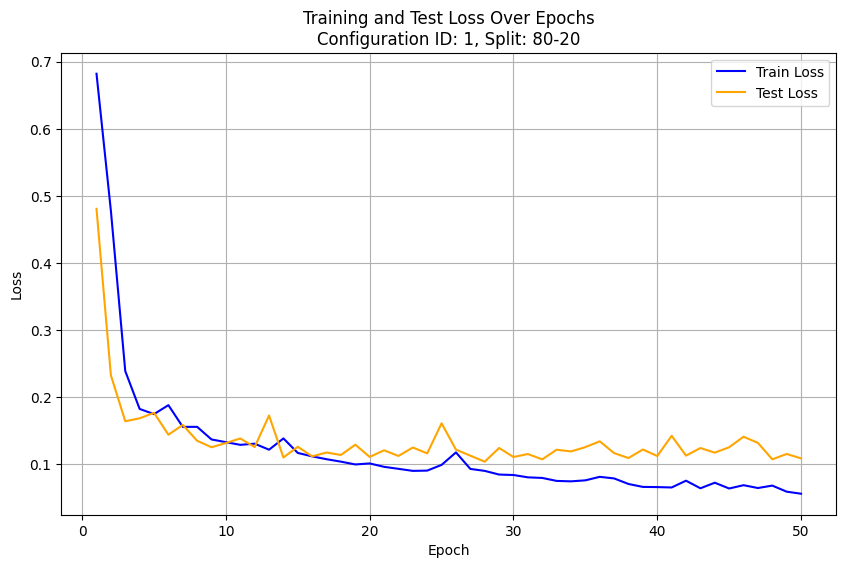

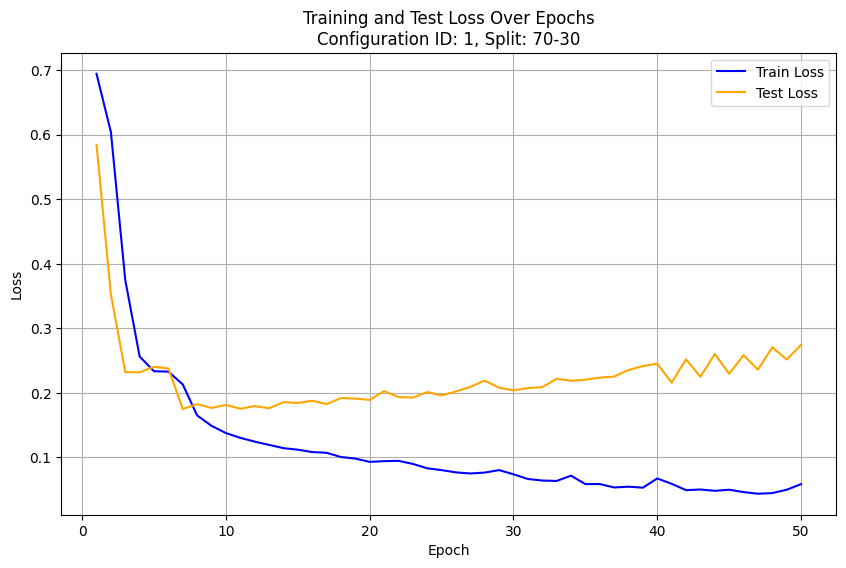

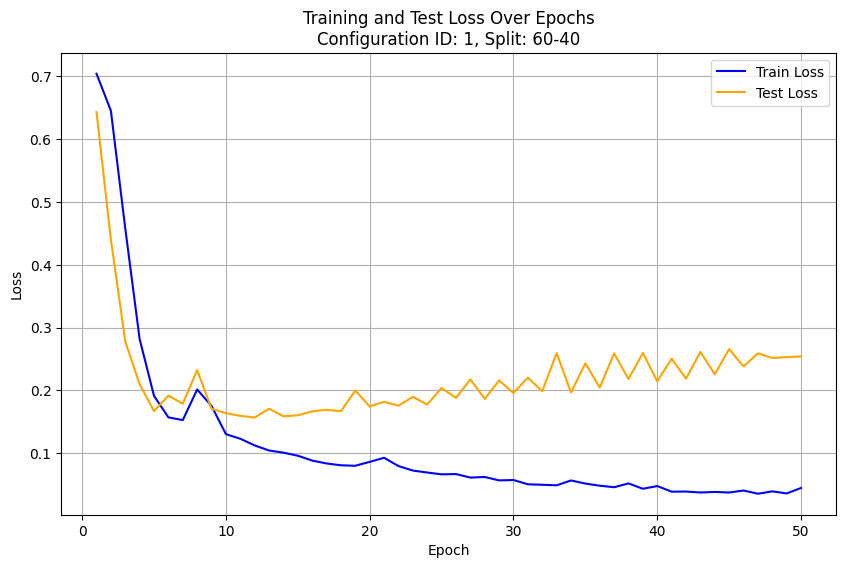

In [174]:
# Iterate over the top configurations
for idx, config in top_3_df.iterrows():
    config_id = idx + 1 
    hidden_layers = config['hidden_layers']
    learning_rate = config['learning_rate']
    activation = config['activation']
    optimizer_name = config['optimizer']
    epochs = config['epochs']
    dataset_path = config['dataset']
    dataset_directory = '/media/abood/windowsdatassd2/coursework/datasets/1_binary/processed/'
    dataset_full_path = os.path.join(dataset_directory, dataset_path)
    if not os.path.isfile(dataset_full_path):
        print(f"Dataset file '{dataset_full_path}' does not exist. Skipping Configuration {config_id}.")
        continue

    dataset_name = dataset_path.replace('.csv', '')

    # Load and preprocess data
    X_full, y_full = load_data(dataset_full_path)

    # Loop through different split types
    for split_type, ratios in split_ratios.items():
        
        # Initialize lists to store losses
        train_losses = []
        test_losses = []

        # Perform train-test split
        X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
            X_full.cpu().numpy(), y_full.cpu().numpy().ravel(),
            train_size=ratios['train_size'], test_size=ratios['test_size'],
            stratify=y_full.cpu().numpy().ravel(), random_state=42
        )
        
        # Convert back to pytorch tensors as done earlier
        X_train_split = torch.tensor(X_train_split, dtype=torch.float32).to(device)
        y_train_split = torch.tensor(y_train_split, dtype=torch.float32).view(-1, 1).to(device)
        X_test_split = torch.tensor(X_test_split, dtype=torch.float32).to(device)
        y_test_split = torch.tensor(y_test_split, dtype=torch.float32).view(-1, 1).to(device)
        
        # Use the architecures for training 
        model = ConfigurableMLP(input_dim=X_train_split.shape[1], hidden_layers=hidden_layers, activation=activation).to(device)

        if optimizer_name.lower() == 'adam':
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        elif optimizer_name.lower() == 'sgd':
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        elif optimizer_name.lower() == 'rmsprop':
            optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
        else:
            print(f"Unsupported optimizer: {optimizer_name}. Skipping this split.")
            continue

        criterion = nn.BCELoss()
        model.train()

        # Training loop
        for epoch_num in range(1, epochs + 1):
            optimizer.zero_grad()
            y_pred = model(X_train_split)
            loss = criterion(y_pred, y_train_split)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
            model.eval()
            with torch.no_grad():
                y_test_pred_prob = model(X_test_split)
                test_loss = criterion(y_test_pred_prob, y_test_split).item()
                test_losses.append(test_loss)


            model.train()


        model.eval()
        with torch.no_grad():
            y_train_pred_prob = model(X_train_split)
            y_train_pred = (y_train_pred_prob > 0.5).cpu().numpy().astype(int).ravel()


        with torch.no_grad():
            y_test_pred_prob = model(X_test_split)
            y_test_pred = (y_test_pred_prob > 0.5).cpu().numpy().astype(int).ravel()

        # Compute metrics
        train_metrics = compute_metrics(y_train_split.cpu().numpy(), y_train_pred, y_train_pred_prob.cpu().numpy())
        test_metrics = compute_metrics(y_test_split.cpu().numpy(), y_test_pred, y_test_pred_prob.cpu().numpy())

        # Record the results
        experiment_results.append({
            'Configuration_ID': config_id,
            'Dataset': dataset_name,
            'Hidden_Layers': hidden_layers,
            'Learning_Rate': learning_rate,
            'Activation': activation,
            'Optimizer': optimizer_name,
            'Epochs': epochs,
            'Split_Type': split_type,
            'Train_Accuracy': train_metrics['Accuracy'],
            'Train_Precision': train_metrics['Precision'],
            'Train_Recall': train_metrics['Recall'],
            'Train_F1_Score': train_metrics['F1 Score'],
            'Train_Specificity': train_metrics['Specificity'],
            'Train_Sensitivity': train_metrics['Sensitivity'],
            'Train_AUC': train_metrics['AUC'],
            'Test_Accuracy': test_metrics['Accuracy'],
            'Test_Precision': test_metrics['Precision'],
            'Test_Recall': test_metrics['Recall'],
            'Test_F1_Score': test_metrics['F1 Score'],
            'Test_Specificity': test_metrics['Specificity'],
            'Test_Sensitivity': test_metrics['Sensitivity'],
            'Test_AUC': test_metrics['AUC'],
            'y_test': y_test_split.cpu().numpy().tolist(),
            'y_pred': y_test_pred.tolist()
        })

        # Plot Training and Test Loss
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
        plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Training and Test Loss Over Epochs\nConfiguration ID: {config_id}, Split: {split_type}')
        plt.legend()
        plt.grid(True)
        plt.show()



# Convert the experiment results to a  a pandas dataFrame for further analysis
all_results_df = pd.DataFrame(experiment_results)

# Save the entire results DataFrame to a CSV file
final_output_csv_path = '/media/abood/windowsdatassd2/coursework/R5(Neural Networks)/final_experiment_results.csv'
all_results_df.to_csv(final_output_csv_path, index=False)



# Calculate the difference between Train and Test Accuracy
all_results_df['Accuracy_Difference'] = all_results_df['Train_Accuracy'] - all_results_df['Test_Accuracy']

### Overfitting Analysis

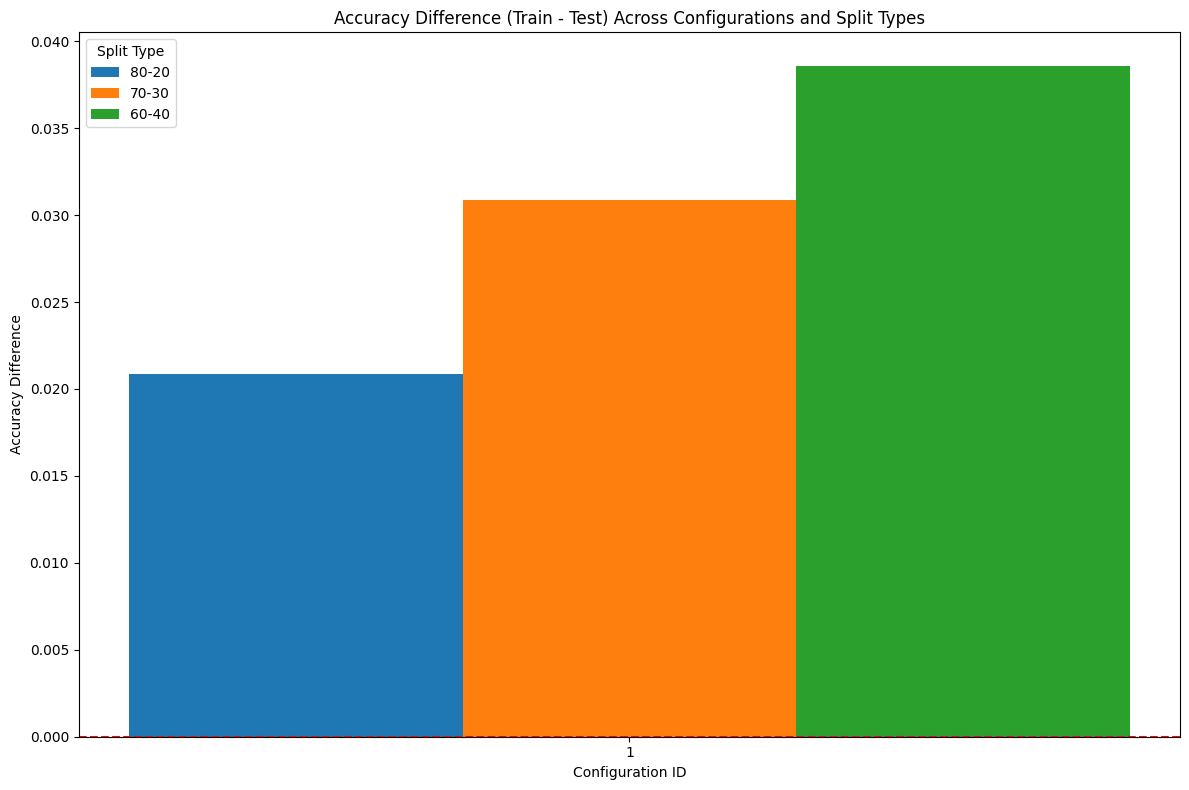

In [175]:
# Plot the differnces between train and test acurracy for every configuration
plt.figure(figsize=(12, 8))
bar_width = 0.2
configurations = sorted(all_results_df['Configuration_ID'].unique())
indices = np.arange(1, len(configurations) + 1)
aggregated_df = all_results_df.groupby(['Configuration_ID', 'Split_Type'])['Accuracy_Difference'].mean().reset_index()

for i, split in enumerate(split_ratios.keys()):
    split_subset = aggregated_df[aggregated_df['Split_Type'] == split].sort_values('Configuration_ID')
    accuracy_diff = split_subset['Accuracy_Difference'].values
    
    plt.bar(
        indices + i * bar_width,
        accuracy_diff,
        width=bar_width,
        label=split
    )

plt.title("Accuracy Difference (Train - Test) Across Configurations and Split Types")
plt.xlabel("Configuration ID")
plt.ylabel("Accuracy Difference")
plt.axhline(0, color='red', linestyle='--')
plt.legend(title='Split Type')
plt.xticks(indices + bar_width * (len(split_ratios) - 1) / 2, configurations)
plt.tight_layout()
plt.show()


### Plot Best Confusion Matrix

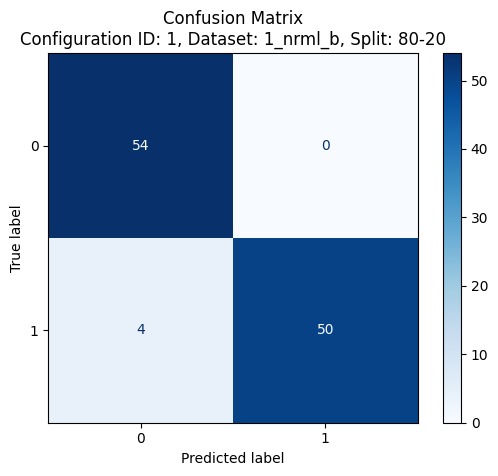

In [195]:
#plot confusion matrix for 80-20 split (the best split)
split_type_of_interest = '80-20'
split_df = all_results_df[all_results_df['Split_Type'] == split_type_of_interest]
y_true = row['y_test']
y_pred = row['y_pred']

# Convert string representations of lists to actual lists 
if isinstance(y_true, str):
    y_true = ast.literal_eval(y_true)
if isinstance(y_pred, str):
    y_pred = ast.literal_eval(y_pred)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)




# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix\nConfiguration ID: {config_id}, Dataset: {dataset_name}, Split: {split_type_of_interest}')
plt.show()
